# Segmenting & Clustering Neighborhoods in Toronto

This workbook will be clearly annoted to explain code during this assignment

In [2]:
#import libraries

import pandas as pd
import numpy as np

In [3]:
#fetch data

data_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df = pd.read_html(data_url)

#convert scrape to a dataframe
df = pd.DataFrame(df[0])

In [4]:
#check data
print(df.head())

print('Initial table; further actions required')

  Postal code           Borough                Neighborhood
0         M1A      Not assigned                         NaN
1         M2A      Not assigned                         NaN
2         M3A        North York                   Parkwoods
3         M4A        North York            Victoria Village
4         M5A  Downtown Toronto  Regent Park / Harbourfront
Initial table; further actions required


In [5]:
#need to drop rows with no Borough - find their index first

indexNames = df[df['Borough']=='Not assigned'].index

#then drop them
df.drop(indexNames, inplace=True)

#recheck
df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [6]:
#identify any duplicate postal code areas for concatenation by grouping by postal code and looking for row counts > 1
df_grp = df.groupby(by="Postal code").count()
df_grp.columns = ["Count Borough","Count Neighborhood"]
#postal codes with row counts shown
df_grp.head()

,Count Borough,Count Neighborhood
Postal code,,
M1B,1,1
M1C,1,1
M1E,1,1
M1G,1,1
M1H,1,1


In [7]:
check = df_grp[df_grp["Count Borough"]>1]
check.shape
rows,cols = check.shape

In [8]:
print("There are {} Postal Code areas with duplicate values".format(rows))

#/REVIEWER NOTE:
#apparently this dataset has been cleaned since the assignment was designed!
#/NOTE

There are 0 Postal Code areas with duplicate values


In [9]:
#fix records with no neighborhood assigned

df_nh = df[df["Neighborhood"]=='Not assigned']
print(df_nh.shape)
print(df_nh.head())

rows,cols = df_nh.shape

#/REVIEWER NOTE:
#apparently this dataset has been cleaned since the assignment was designed!
#/NOTE

(0, 3)
Empty DataFrame
Columns: [Postal code, Borough, Neighborhood]
Index: []


In [10]:
print("There are {} Neighborhood areas with missing values".format(rows))

There are 0 Neighborhood areas with missing values


### Q1 Answer: The data is now prepared for use in the following format

In [11]:
df.head(10)

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge
11,M3B,North York,Don Mills
12,M4B,East York,Parkview Hill / Woodbine Gardens
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [12]:
print(df.shape)
rows,cols = df.shape
print("There are {} rows and {} columns in this clean dataset".format(rows, cols))

(103, 3)
There are 103 rows and 3 columns in this clean dataset


## This is the end of Part 1

## Part 2

This section requires lat and long data be added to each postal area for subsequent use

In [13]:
#the Geocoder method sounds flaky, so go straight to using the cocl.us csv data

#create a new dataframe for this geospacial data - we will join to the existing dataframe later

geo=pd.read_csv("https://cocl.us/Geospatial_data")

geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
#the data is in an easy to use format and we can join the dataframes using Postal Code

full_df = pd.merge(df,geo,how='outer',left_on="Postal code", right_on="Postal Code")

In [15]:
#check the success of the merge
full_df.head()

,Postal code,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,M5A,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,M7A,43.662301,-79.389494


In [16]:
#check shape of resulting dataframe
full_df.shape

(103, 6)

## Question 2 Answer

In [17]:
#no new rows have been created, so tidy the result as we have duplicate Postal Code columns
full_df.drop("Postal Code",axis=1,inplace=True)
full_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [18]:
#lets confirm how many unique Neighborhoods there are

n_check = full_df.groupby('Neighborhood').count().shape[0]
n_check

98

## This is end of Part 2

## Part 3

This section will enrich the data with information from Foursquare, perform any one-hot encoding and cluster Toronto neighborhoods

The aim of the clustering will be to create a 'foodie map' showing areas by their similarity of restaurants and cafes, etc

In [21]:
## import additional libraries
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # required
!pip install folium
import folium # map rendering library

##/ import

     |████████████████████████████████| 92kB 6.5MB/s eta 0:00:011


creating Foursquare credentials in hidden cell



In [22]:
# @hidden_cell

CLIENT_ID = 'Z4CIAMVHL1PW33YEFLTW2FWCMZQO1GLEW1E0Z5QQN5SIROIU' # your Foursquare ID
CLIENT_SECRET = 'JD3NC5LWKKDS3ZGQ2QYGGAYD2CUVZE0MKPKCLJHXKZLQUPLU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [293]:
# setup additional Foursquare parameters

radius = 250 #set 250m proximity radius from centre of neighborhood
LIMIT = 100 #return max 100 rows per request


In [294]:
#reuse the 'getNearbyVenues' function from lab

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [295]:
#create a new dataframe to get toronto venue information from foursquare

toronto_venues = getNearbyVenues(names=full_df['Neighborhood'],
                                latitudes=full_df['Latitude'],
                                longitudes=full_df['Longitude'])

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Do

In [296]:
#review the gathered data

print(toronto_venues.shape)
toronto_venues.head()

(2154, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


### we are creating a 'foodie map' so are only interested in a subset of the venue categories - lets review what they are

In [297]:
venues_grp = toronto_venues.groupby(by="Venue Category").count()
venues_grp

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,1,1,1,1,1,1
Airport,2,2,2,2,2,2
Airport Food Court,1,1,1,1,1,1
Airport Gate,1,1,1,1,1,1
Airport Lounge,1,1,1,1,1,1
Airport Service,2,2,2,2,2,2
Airport Terminal,1,1,1,1,1,1
American Restaurant,29,29,29,29,29,29
Antique Shop,3,3,3,3,3,3


In [298]:
#There are a lot of categories, so lets just keep anything containing 'restaurant', 'joint' or 'cafe'

subset=venues_grp[venues_grp.index.str.contains('Restaurant|Cafe|Joint')]

#drop obsolete columns and reorient frame to use in inner join later
#subset = subset.reset_index(inplace=True)
subset.drop(["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude", "Venue", "Venue Latitude", "Venue Longitude"], axis=1, inplace=True)
subset

#try dropping 'Restaurant' as it is a dominant type of location and doesnt help in clustering by type of venue

subset.drop('Restaurant', inplace=True)
subset

#we now have the subset of venue types we are interested in

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


""
Venue Category
American Restaurant
Asian Restaurant
BBQ Joint
Belgian Restaurant
Brazilian Restaurant
Burger Joint
Cajun / Creole Restaurant
Caribbean Restaurant
Chinese Restaurant


In [329]:
#lets perform an inner join on toronto_venues to remove any data relating to non-foodie venues

toronto_venues = pd.merge(left=toronto_venues, right=subset, how='inner', left_on="Venue Category", right_on="Venue Category")

print(toronto_venues.shape) # there are 460 restaurants in the set at the time of writing
toronto_venues.head()

(460, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
1,Regent Park / Harbourfront,43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
2,St. James Town,43.651494,-79.375418,Biff's Bistro,43.647085,-79.376342,French Restaurant
3,Berczy Park,43.644771,-79.373306,Biff's Bistro,43.647085,-79.376342,French Restaurant
4,Central Bay Street,43.657952,-79.387383,Midi Bistro,43.655871,-79.392091,French Restaurant


In [300]:
#let's quickly check that there are only foodie locations in the updated frame

check = toronto_venues.groupby(by="Venue Category").count()
check

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
American Restaurant,29,29,29,29,29,29
Asian Restaurant,13,13,13,13,13,13
BBQ Joint,4,4,4,4,4,4
Belgian Restaurant,2,2,2,2,2,2
Brazilian Restaurant,2,2,2,2,2,2
Burger Joint,17,17,17,17,17,17
Cajun / Creole Restaurant,1,1,1,1,1,1
Caribbean Restaurant,8,8,8,8,8,8
Chinese Restaurant,19,19,19,19,19,19


### looks good, lets move on

In [301]:
#lets use onehot encoding to analyse this data

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#retain Neighborhood name

toronto_onehot['Neighborhood']=toronto_venues['Neighborhood']

#move Neighborhood name to the first column

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,Burger Joint,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,...,South American Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Regent Park / Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,St. James Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [302]:
#check the size of this dataframe
toronto_onehot.shape

(460, 55)

In [303]:
#we need to regroup the rows and do something with the boolean onehot data. As per the lab, we will take the mean of the frequency of each cat

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,Burger Joint,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,...,South American Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000
1,Bathurst Manor / Wilson Heights / Downsview North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.250000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000
2,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000
3,Bedford Park / Lawrence Manor East,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.100000,0.000000,0.000000,0.200000,0.00,0.0,0.000000,0.000000,0.000000
4,Berczy Park,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.076923,0.00,0.0,0.076923,0.000000,0.000000
5,Brockton / Parkdale Village / Exhibition Place,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000
6,Business reply mail Processing CentrE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000
7,Canada Post Gateway Processing Centre,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000
8,Cedarbrae,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.00,0.0,0.000000,0.000000,0.000000
9,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000,0.000000,0.052632,...,0.000000,0.105263,0.000000,0.000000,0.052632,0.00,0.0,0.052632,0.000000,0.000000


In [304]:
print(toronto_grouped.shape)
rows, cols = toronto_grouped.shape
print("Note that there are {} Neighborhoods in this analysis, this means {} Neighborhoods have no foodie locations but need to be included in the clustering" .format(rows, str(n_check-rows)))

(65, 55)
Note that there are 65 Neighborhoods in this analysis, this means 33 Neighborhoods have no foodie locations but need to be included in the clustering


In [305]:
#identify the missing Neighborhoods and create records with '0' mean for every foodie type

#create column headers for dummy data
headers = toronto_grouped.columns

#get list of Neighborhoods with no foodie venues

missing_df = pd.merge(left=full_df, right=toronto_grouped, how='outer', indicator='indicator_column')
missing_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,indicator_column
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,both
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both


In [306]:
#keep only those records where 'indicator_column' is left only (i.e. only appears in master list)

missing_df=missing_df[missing_df["indicator_column"]=='left_only']

# then replace all NaN with 0 as the number of restaurants of each type in this areas is 0
#missing_df.cat.add_categories("missing").fillna("missing")
missing_df.replace(np.nan, 0, inplace=True)
missing_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,indicator_column
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,left_only
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,left_only
12,M9B,Etobicoke,West Deane Park / Princess Gardens / Martin Gr...,43.650943,-79.554724,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,left_only
13,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,left_only
14,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,left_only


In [307]:
#check number of non-foodie neighborhoods being added by this method

missing_df.shape

#there are duplicated rows, lets groupby and compress these away

(36, 60)

In [308]:
missing_df=missing_df.groupby('Neighborhood').mean().reset_index()
missing_df

,Neighborhood,Latitude,Longitude,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,Burger Joint,Cajun / Creole Restaurant,...,South American Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alderwood / Long Branch,43.602414,-79.543484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Birch Cliff / Cliffside West,43.692657,-79.264848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CN Tower / King and Spadina / Railway Lands / ...,43.628947,-79.394420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Caledonia-Fairbanks,43.689026,-79.453512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Davisville North,43.712751,-79.390197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Downsview,43.741654,-79.497101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,East Toronto,43.685347,-79.338106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Eringate / Bloordale Gardens / Old Burnhamthor...,43.643515,-79.577201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Golden Mile / Clairlea / Oakridge,43.711112,-79.284577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Humberlea / Emery,43.724766,-79.532242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [309]:
#drop lat and long to give same no features
missing_df.drop(['Latitude','Longitude'], axis=1, inplace=True)
missing_df.head()

#we have isolated the missing 32 rows and columns, we can recombine the data

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,Burger Joint,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,...,South American Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alderwood / Long Branch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Birch Cliff / Cliffside West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CN Tower / King and Spadina / Railway Lands / ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Caledonia-Fairbanks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Davisville North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [407]:
combined_onehot = pd.concat([toronto_grouped, missing_df])
combined_onehot.shape

(98, 55)

In [408]:
#Undertake Feature Scaling

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#define featureset
toronto_grouped_clustering = combined_onehot.drop(['Neighborhood'],1)
scaled_X = StandardScaler().fit_transform(toronto_grouped_clustering)

### Begin Clustering Process

In [409]:
#set number of clusters

kclusters = 10


#run clustering
kmeans = KMeans(n_clusters=kclusters, random_state=15).fit(scaled_X)

#check generated labels

print(kmeans.labels_[0:10])
#evaluate performance with this k
print(kmeans.inertia_) #Squared Error

[1 1 1 1 1 1 1 1 1 1]
3310.838097960621


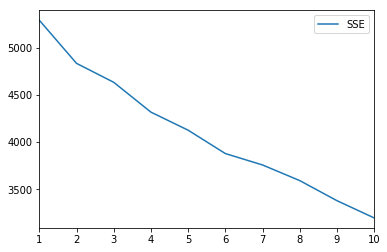

In [410]:
#perform elbow analysis to determine best k

k_set = list(range(1,11))
k_set

results = {}

for k in k_set:
    kmeans=KMeans(n_clusters=k).fit(scaled_X)
    results[k]=kmeans.inertia_
    
k_chart = pd.DataFrame.from_dict(results,orient='index')
k_chart.columns=['SSE']
k_chart
k_chart.plot()
    
#there is no clear elbow suggesting no obvious choice for k

In [411]:
#retrain clusters using k=5

kclusters = 5


#run clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(scaled_X)


In [412]:
#create df with labels

combined_onehot.insert(0,'Cluster Labels',kmeans.labels_)
labelled_df = combined_onehot
labelled_df.head()

,Cluster Labels,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,Burger Joint,Cajun / Creole Restaurant,Caribbean Restaurant,...,South American Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,2,Agincourt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,2,Bayview Village,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,2,Bedford Park / Lawrence Manor East,0.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0
4,1,Berczy Park,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.076923,0.0,0.0,0.076923,0.0,0.0


In [413]:
check = labelled_df.groupby("Cluster Labels").count()

In [414]:
check # lets review how many rows have been allocated to each cluster

#store this for later evaluation
cluster_counts = check[['Neighborhood']]
cluster_counts

,Neighborhood
Cluster Labels,
0,4
1,8
2,84
3,1
4,1


In [415]:
# merge the clustering group into the original descriptive data

final_df = pd.merge(full_df, labelled_df, how='inner', on='Neighborhood')

final_df = final_df.iloc[:,:6]

final_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,2
1,M4A,North York,Victoria Village,43.725882,-79.315572,2
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,2
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,2
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,2


### Clustering Generated

Move on to mapping the new clusters and providing some insight

In [416]:
#create map

toronto_map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

#set colour scheme
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to map

markers_colors = []

for lat, lon, poi, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map)


toronto_map

### Review Clusters

In [417]:
#enrich summary data to determine characteristics of each group

#get 'number of restaurants per neighbourhood'

venues_by_nh = toronto_venues.groupby('Neighborhood').count()
venues_by_nh = venues_by_nh.iloc[:,:1]
venues_by_nh.columns=['Count']
venues_by_nh.head()

,Count
Neighborhood,
Agincourt,1
Bathurst Manor / Wilson Heights / Downsview North,4
Bayview Village,2
Bedford Park / Lawrence Manor East,10
Berczy Park,13


In [430]:
#undertake some evaluation - lets see if the average number of venues in each neighborhood, by cluster adds any value to understanding the labels..

eval_df=pd.merge(final_df, venues_by_nh, how='inner',on='Neighborhood')
eval_df.sort_values(by=['Cluster Labels','Count'],ascending=False, inplace=True)
eval_df.head(10)


,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Count
56,M5T,Downtown Toronto,Kensington Market / Chinatown / Grange Park,43.653206,-79.400049,4,23
49,M6R,West Toronto,Parkdale / Roncesvalles,43.648960,-79.456325,3,3
10,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,21
64,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2,20
29,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188,2,14
23,M2J,North York,Fairview / Henry Farm / Oriole,43.778517,-79.346556,2,11
37,M5M,North York,Bedford Park / Lawrence Manor East,43.733283,-79.419750,2,10
39,M2N,North York,Willowdale,43.770120,-79.408493,2,10
40,M2R,North York,Willowdale,43.782736,-79.442259,2,10
62,M4X,Downtown Toronto,St. James Town / Cabbagetown,43.667967,-79.367675,2,9


In [419]:
#get average number of venues in neighborhood by cluster label
review = eval_df.groupby('Cluster Labels').mean()
review=review[['Count']]


#merge in total number of neighborhoods by cluster

review=pd.merge(review, cluster_counts, on='Cluster Labels')
review.columns=['Average Venues per Neighborhood', 'Neighborhoods in Cluster']
review

,Average Venues per Neighborhood,Neighborhoods in Cluster
Cluster Labels,,
0,18.000000,4
1,17.250000,8
2,4.566038,84
3,3.000000,1
4,23.000000,1


In [425]:
#lets add cluster to toronto_venues and summarise each cluster with its top 5 foodie locations

venues_cl = pd.merge(toronto_venues,final_df,on='Neighborhood')
#summarise by cluster


for i in list(range(0,kclusters)):
    summary = venues_cl[venues_cl['Cluster Labels']==i].groupby(['Venue Category']).count()
    summary.sort_values(by=['Neighborhood'], ascending=False, inplace=True)
    summary = summary[['Neighborhood']]
    summary.columns=['Top 6 Foodie Venues in Cluster {}'.format(i)]
    print(summary.head(6))


#print each clusters top venues to add flavour to analysis


                           Top 6 Foodie Venues in Cluster 0
Venue Category                                             
Italian Restaurant                                        9
Japanese Restaurant                                       6
Sushi Restaurant                                          6
Thai Restaurant                                           5
Middle Eastern Restaurant                                 4
Burger Joint                                              4
                               Top 6 Foodie Venues in Cluster 1
Venue Category                                                 
Italian Restaurant                                           19
Seafood Restaurant                                           15
Japanese Restaurant                                          15
American Restaurant                                          12
Vegetarian / Vegan Restaurant                                10
Asian Restaurant                                              7
        

## Concluding Remarks


It has been difficult to choose the ideal k for this exercise and I haven't received an ideal result, but the current settings allow for some meaning to be given to each cluster

Cluster 0 - 'Downtown Eating' - Foodie Rating 4* - Lots of Venues in the neighborhood - "Best Place to Find Middle Eastern"

Cluster 1 - 'Waterfront Eating' - Foodie Rating 4* - Lots of Venues in the neighborhood - "Good for Vegans and Fish Lovers"

Cluster 2 - 'Suburbs' - Foodie Rating 2* - Covers most of the greater Toronto area - not many venues on average - "Check before you visit"

Cluster 3 - 'High Park' - Foodie Rating 1* - "Go for a walk instead"

Cluster 4 - 'Foodie Central' - Foodie Rating 5* - The most Venues of any neighborhood cluster - "Must Visit" 